In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

In [2]:
hparams = AttrDict(
    image_size=(64, 64, 3),
    n_classes=4,
    batch_size=64,
    validation_split=0.25
)

generator = ImageDataGenerator(
    rotation_range =10, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,  
    rescale=1./255, 
    # shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip = True, 
    vertical_flip = True, 
    fill_mode = 'nearest', 
    brightness_range=[0.5, 1.5],
    validation_split=hparams.validation_split) 

train_ds = generator.flow_from_directory(
        'dataset',
        target_size=hparams.image_size[:-1],
        batch_size=hparams.batch_size,
        class_mode='sparse',
        subset="training")

validation_ds = generator.flow_from_directory(
        'dataset',
        target_size=hparams.image_size[:-1],
        batch_size=hparams.batch_size,
        class_mode='sparse',
        subset="validation")

Found 2450 images belonging to 4 classes.
Found 815 images belonging to 4 classes.


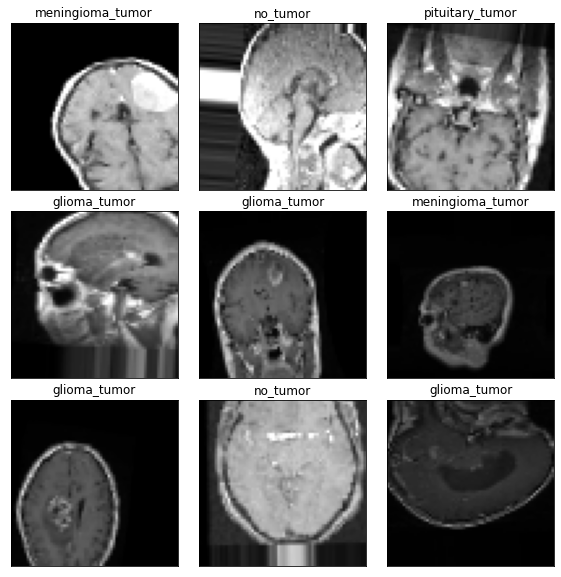

In [3]:
_ = plot_grid_ds(train_ds)

In [4]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
fitted = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
39/39 [==============================] - 21s 376ms/step - loss: 4.8326 - accuracy: 0.2862 - balanced_sparse_categorical_accuracy: 0.2762 - val_loss: 1.3767 - val_a

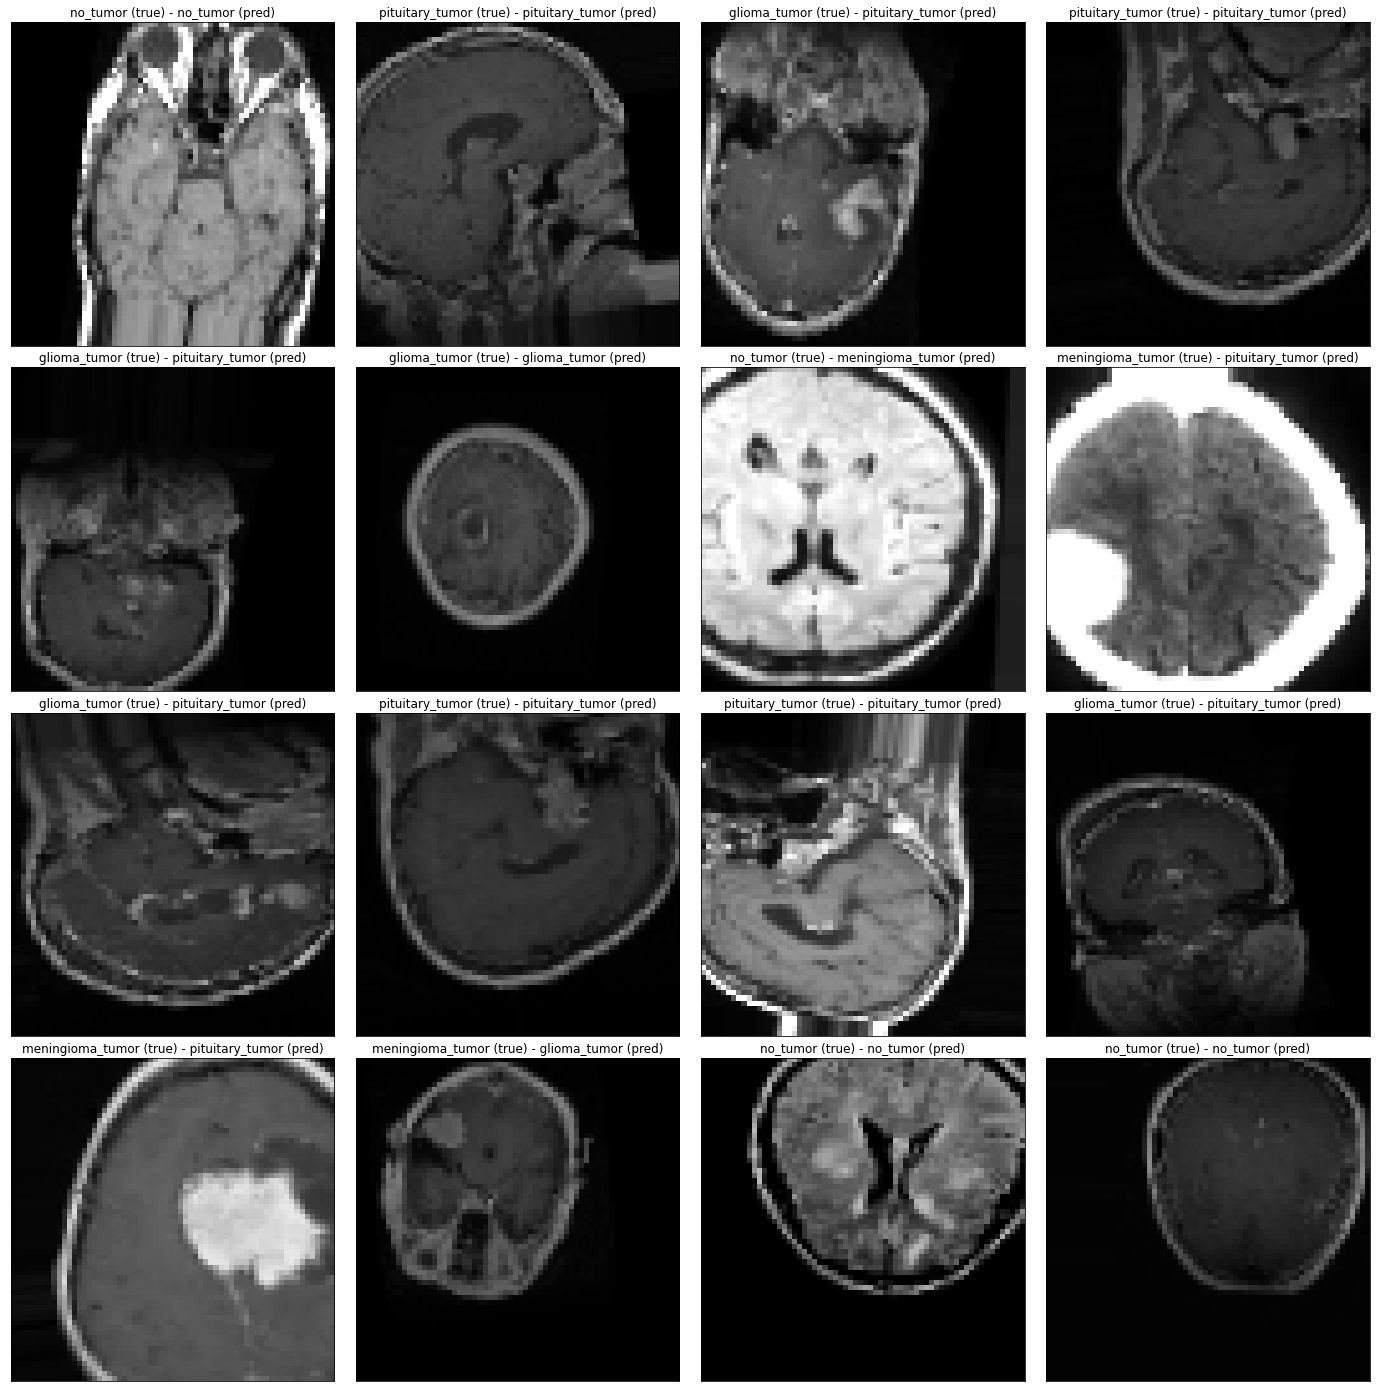

In [6]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize=(25, 25))

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix

X, y_true = next(validation_ds)
for _ in range(10):
    x, y = next(validation_ds) 
    X = np.r_[X, x]
    y_true = np.r_[y_true, y]
    
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[ 70,  57,   2,  77],
       [119,  20,  15,  38],
       [ 19,  17,  33,  31],
       [  8,  17,   2, 162]])

In [23]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.394


In [ ]:
model.save("models/ViT_on_10_epochs.model")